In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

In [3]:
#Access to datasets
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.datasets import mnist

(x_train, y_train),(x_test, y_test)=mnist.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

11493376/11490434 [==============================] - 15s    
Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [4]:
#Display as text
from IPython.display import display
import pandas as pd

print("Shape for dataset: {}".format(x_train.shape))
print("Labels: {}".format(y_train))

#Single MNIST
single=x_train[0]
print("Shape for single: {}".format(single.shape))

display(pd.DataFrame(single.reshape(28,28)))

Shape for dataset: (60000, 28, 28)
Labels: [5 0 4 ..., 5 6 8]
Shape fro single: (28, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,...,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,...,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,...,0,0,0,0,0,0,0,0,0,0


In [5]:
single

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Image (#900): Which is digit 9


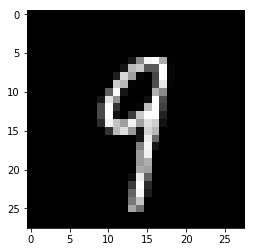

In [9]:
#Display as Image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit=900
a =x_train[digit]
plt.imshow(a,cmap='gray',interpolation='nearest')
print("Image (#{}): Which is digit {}".format(digit,y_train[digit]))

In [11]:
#Define The CNN
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
batch_size=128
num_classes=10
epochs =12
#input image dimensions
img_rows, img_cols =28, 28
if K.image_data_format()=='channels_first':
    x_train=x_train.reshape(x_train.shape[0],1,img_rows,img_cols)
    x_test=x_test.reshape(x_test.shape[0],1,img_rows, img_cols)
    input_shape=(1, img_rows, img_cols)
else:
    x_train=x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
    x_test=x_test.reshape(x_test.shape[0],img_rows,img_cols,1)
    input_shape=(img_rows,img_cols,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape: {}'.format(x_train.shape))
print('Training samples: {}'.format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

#Convert class vectors to binary class matrices

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])


x_train shape: (60000, 28, 28, 1)
Training samples: 60000
Test samples: 10000
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
#Training / Fitting CNN
import tensorflow as tf
import time

start_time=time.time()

model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(x_test,y_test))
score=model.evaluate(x_test,y_test,verbose=0)
print('Test Loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time=time.time()-start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
173s - loss: 0.3426 - acc: 0.8966 - val_loss: 0.0817 - val_acc: 0.9750
Epoch 2/12
167s - loss: 0.1183 - acc: 0.9655 - val_loss: 0.0579 - val_acc: 0.9816
Epoch 3/12
167s - loss: 0.0886 - acc: 0.9736 - val_loss: 0.0475 - val_acc: 0.9849
Epoch 4/12
165s - loss: 0.0727 - acc: 0.9782 - val_loss: 0.0414 - val_acc: 0.9867
Epoch 5/12
171s - loss: 0.0638 - acc: 0.9809 - val_loss: 0.0371 - val_acc: 0.9881
Epoch 6/12
171s - loss: 0.0581 - acc: 0.9824 - val_loss: 0.0344 - val_acc: 0.9890
Epoch 7/12
172s - loss: 0.0539 - acc: 0.9838 - val_loss: 0.0347 - val_acc: 0.9888
Epoch 8/12
186s - loss: 0.0486 - acc: 0.9854 - val_loss: 0.0309 - val_acc: 0.9899
Epoch 9/12
185s - loss: 0.0443 - acc: 0.9862 - val_loss: 0.0318 - val_acc: 0.9896
Epoch 10/12
198s - loss: 0.0418 - acc: 0.9876 - val_loss: 0.0305 - val_acc: 0.9899
Epoch 11/12
185s - loss: 0.0402 - acc: 0.9879 - val_loss: 0.0325 - val_acc: 0.9892
Epoch 12/12
186s - loss: 0.0377 - acc: 0.9888 

In [13]:
score=model.evaluate(x_test,y_test,verbose=0)
print('Test Loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))
print(score)

Test Loss: 0.03061697123310296
Test accuracy: 0.9902
[0.03061697123310296, 0.99019999999999997]
